In [1]:
!conda list

# packages in environment at /root/miniconda3:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main    defaults
_openmp_mutex             4.5                       1_gnu    defaults
absl-py                   1.0.0                    pypi_0    pypi
anyio                     3.4.0                    pypi_0    pypi
argon2-cffi               21.1.0                   pypi_0    pypi
attrs                     21.2.0                   pypi_0    pypi
babel                     2.9.1                    pypi_0    pypi
backcall                  0.2.0                    pypi_0    pypi
bleach                    4.1.0                    pypi_0    pypi
brotlipy                  0.7.0           py38h27cfd23_1003    defaults
ca-certificates           2021.7.5             h06a4308_1    defaults
cachetools                4.2.4                    pypi_0    pypi
certifi                   2021.5.30        py38h06a4308_0    defaults
cffi

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.neighbors import kneighbors_graph
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from models.GCN import GCN
from models.RNN import RNN
from models.SVM import SVM
from models.DecisionTree import DecisionTreeID3, DecisionTreeCART
from models.LogisticRegression import LogisticRegression
from models.CNN import SimpleCNN
import dgl

2024-11-17 16:58:11.093090: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-17 16:58:11.938890: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-11-17 16:58:11.938972: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-11-17 16:58:11.938976: W tensorfl

In [3]:
# 使用KNN图构建
def create_graph_from_data(features, n_neighbors=15):  # 增加邻居数
    knn_graph = kneighbors_graph(features, n_neighbors=n_neighbors, mode='connectivity', include_self=False)
    knn_graph = knn_graph.astype(np.float32).todense()

    # 转换为DGL图
    src, dst = np.where(knn_graph > 0)  # 获取非零元素的索引
    src = torch.tensor(src, dtype=torch.int64)
    dst = torch.tensor(dst, dtype=torch.int64)

    # 创建DGL图
    g = dgl.graph((src, dst))
    g.ndata['feat'] = torch.tensor(features, dtype=torch.float32)

    # 计算节点度数并进行归一化
    in_degrees = g.in_degrees().float()
    norm = 1.0 / in_degrees
    g.ndata['norm'] = norm

    return g

In [4]:
# 读取数据
mushroom_data = pd.read_csv('data/mushrooms.csv', dtype=str)

In [5]:
# 分离目标和特征
target = mushroom_data['class']
inputs = mushroom_data.drop(['class'], axis=1)

In [6]:
# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=24, stratify=target)

In [7]:
# 编码
enc_i = OrdinalEncoder()
enc_t = LabelEncoder()

x_train_transf = enc_i.fit_transform(X_train)
x_test_transf = enc_i.transform(X_test)

y_train_transf = enc_t.fit_transform(y_train)
y_test_transf = enc_t.transform(y_test)

In [8]:
# 确定分类任务的类别数
num_classes = len(np.unique(y_train_transf))

In [9]:
# 构建训练图
X_train_tensor = torch.tensor(x_train_transf, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_transf, dtype=torch.long)
X_test_tensor = torch.tensor(x_test_transf, dtype=torch.float32)

# 数据标准化
X_train_tensor = F.normalize(X_train_tensor, p=2, dim=1)
X_test_tensor = F.normalize(X_test_tensor, p=2, dim=1)

In [10]:
# 标准化数据
scaler = StandardScaler()
x_train_transf_scaler = scaler.fit_transform(x_train_transf)
x_test_transf_scaler = scaler.transform(x_test_transf)

In [11]:
# 初始化并训练Logistic Regression模型
log_reg_model = LogisticRegression(learning_rate=0.01, n_iter=1000, verbose=True, early_stopping=True)
log_reg_model.fit(x_train_transf_scaler, y_train_transf)

# 预测与评估
log_reg_predictions = log_reg_model.predict(x_test_transf_scaler)
accuracy_log_reg = accuracy_score(y_test_transf, log_reg_predictions)

# 计算训练集准确率
train_predictions = log_reg_model.predict(x_train_transf_scaler)
train_accuracy = accuracy_score(y_train_transf, train_predictions)
print(f'Training Accuracy (Logistic Regression): {train_accuracy * 100:.2f}%')

# 输出测试准确率
print(f'Test Accuracy (Logistic Regression): {accuracy_log_reg * 100:.2f}%')

Iteration 0: Loss = 0.6931
Iteration 100: Loss = 0.4415
Iteration 200: Loss = 0.3561
Iteration 300: Loss = 0.3149
Iteration 400: Loss = 0.2906
Iteration 500: Loss = 0.2745
Early stopping at iteration 597, Loss = 0.2633
Training Accuracy (Logistic Regression): 90.71%
Test Accuracy (Logistic Regression): 89.78%


In [12]:
# 初始化并训练SVM模型
svm_model = SVM(C=1.0, kernel='linear', max_iter=100)
svm_model.fit(x_train_transf_scaler, y_train_transf)

# 预测与评估
svm_predictions = svm_model.predict(x_test_transf_scaler)
accuracy_svm = accuracy_score(y_test_transf, svm_predictions)

# 输出测试准确率
print(f'Test Accuracy (SVM): {accuracy_svm * 100:.2f}%')

Epoch 0, Loss: 422.8684, Train Accuracy: 0.9109
Epoch 10, Loss: 47235.7849, Train Accuracy: 0.7093
Epoch 20, Loss: 143920.1659, Train Accuracy: 0.8320
Epoch 30, Loss: 201551.0919, Train Accuracy: 0.9680
Epoch 40, Loss: 246391.9606, Train Accuracy: 0.9492
Epoch 50, Loss: 280292.1434, Train Accuracy: 0.9882
Epoch 60, Loss: 304561.5344, Train Accuracy: 0.9895
Epoch 70, Loss: 322022.1849, Train Accuracy: 0.8714
Epoch 80, Loss: 335012.7366, Train Accuracy: 0.9708
Epoch 90, Loss: 343721.4084, Train Accuracy: 0.9886
Test Accuracy (SVM): 47.82%


In [13]:
# 定义超参数
input_size = X_train_tensor.shape[1]
hidden_size = 256
output_size = num_classes
num_layers = 2
learning_rate = 0.01
num_epochs = 100

# 初始化RNN模型
rnn_model = RNN(input_size, hidden_size, output_size, num_layers)
rnn_model = rnn_model.to(X_train_tensor.device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)

# 训练RNN模型
for epoch in range(num_epochs):
    rnn_model.train()
    outputs = rnn_model(X_train_tensor.unsqueeze(1))  # 增加维度以匹配RNN输入
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 测试RNN模型
rnn_model.eval()
with torch.no_grad():
    test_outputs = rnn_model(X_test_tensor.unsqueeze(1))  # 增加维度以匹配RNN输入
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(y_test_transf, predicted.cpu().numpy())
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Epoch [10/100], Loss: 0.4366
Epoch [20/100], Loss: 0.2842
Epoch [30/100], Loss: 0.2407
Epoch [40/100], Loss: 0.2078
Epoch [50/100], Loss: 0.1890
Epoch [60/100], Loss: 0.1928
Epoch [70/100], Loss: 0.1780
Epoch [80/100], Loss: 0.1638
Epoch [90/100], Loss: 0.1589
Epoch [100/100], Loss: 0.1598
Test Accuracy: 93.11%


In [14]:
# 使用ID3算法训练决策树
id3_model = DecisionTreeID3(max_depth=5)  # 可以根据需要调整最大深度
id3_model.fit(x_train_transf, y_train_transf)

# 在测试集上进行预测
id3_predictions = id3_model.predict(x_test_transf)

# 计算准确率
id3_accuracy = accuracy_score(y_test_transf, id3_predictions)
print(f'Test Accuracy (ID3): {id3_accuracy * 100:.2f}%')

Test Accuracy (ID3): 97.66%


In [15]:
# 使用CART算法训练决策树
cart_model = DecisionTreeCART(max_depth=5)  # 可以根据需要调整最大深度
cart_model.fit(x_train_transf, y_train_transf)

# 在测试集上进行预测
cart_predictions = cart_model.predict(x_test_transf)

# 计算准确率
cart_accuracy = accuracy_score(y_test_transf, cart_predictions)
print(f'Test Accuracy (CART): {cart_accuracy * 100:.2f}%')

Test Accuracy (CART): 97.54%


In [20]:
from models.RandomForest import train_random_forest

# 随机森林
rf_model = train_random_forest(x_train_transf_scaler, y_train_transf, x_test_transf_scaler, y_test_transf)

# 预测
rf_predictions = rf_model.predict(x_test_transf_scaler)

# 计算准确率
rf_accuracy = accuracy_score(y_test_transf, rf_predictions)

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       842
           1       0.93      0.97      0.95       783

    accuracy                           0.95      1625
   macro avg       0.95      0.95      0.95      1625
weighted avg       0.95      0.95      0.95      1625

Confusion Matrix:
 [[787  55]
 [ 24 759]]
AUC Score: 0.952013996960348
AP Score: 0.9186213587592897


In [27]:
from models.CNN import SimpleCNN

# 初始化和训练 CNN 模型
input_shape = (x_train_transf_scaler.shape[1], 1)
cnn_model = SimpleCNN(input_shape=input_shape)
cnn_model.train(x_train_transf_scaler, y_train_transf, epochs=20, batch_size=32, validation_split=0.2)

# 评估 CNN 模型
cnn_predictions = cnn_model.predict(x_test_transf_scaler)
cnn_accuracy = accuracy_score(y_test_transf, cnn_predictions)

# 打印 CNN 测试准确率
print(f'Test Accuracy (CNN): {cnn_accuracy * 100:.2f}%')

2024-11-17 17:08:50.550905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20


2024-11-17 17:08:53.939665: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20850 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:a1:00.0, compute capability: 8.6
2024-11-17 17:08:55.633958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2024-11-17 17:08:57.159028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-17 17:08:57.163535: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0xc6968ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-17 17:08:57.163562: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-17 17:08:57.168999: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:26

163/163 [==============================] - 5s 7ms/step - loss: 0.4914 - accuracy: 0.8417 - val_loss: 0.3126 - val_accuracy: 0.9192
Epoch 2/20
163/163 [==============================] - 1s 5ms/step - loss: 0.2589 - accuracy: 0.9142 - val_loss: 0.2020 - val_accuracy: 0.9223
Epoch 3/20
163/163 [==============================] - 1s 5ms/step - loss: 0.1900 - accuracy: 0.9240 - val_loss: 0.1508 - val_accuracy: 0.9446
Epoch 4/20
163/163 [==============================] - 1s 7ms/step - loss: 0.1488 - accuracy: 0.9444 - val_loss: 0.1227 - val_accuracy: 0.9554
Epoch 5/20
163/163 [==============================] - 1s 5ms/step - loss: 0.1289 - accuracy: 0.9483 - val_loss: 0.1030 - val_accuracy: 0.9592
Epoch 6/20
163/163 [==============================] - 1s 5ms/step - loss: 0.1111 - accuracy: 0.9552 - val_loss: 0.0964 - val_accuracy: 0.9646
Epoch 7/20
163/163 [==============================] - 1s 5ms/step - loss: 0.0952 - accuracy: 0.9611 - val_loss: 0.0762 - val_accuracy: 0.9669
Epoch 8/20
163/16

In [28]:
# XGBoost训练
dtrain = xgb.DMatrix(x_train_transf, label=y_train_transf)
dtest = xgb.DMatrix(x_test_transf, label=y_test_transf)

# XGBoost超参数设置
params = {
    'objective': 'binary:logistic',  # 二分类
    'eval_metric': 'logloss',
    'max_depth': 6,  # 树的最大深度
    'eta': 0.1,  # 学习率
    'subsample': 0.8,  # 子样本比例
    'colsample_bytree': 0.8,  # 树的列采样
    'n_jobs': 4
}

# 训练
num_round = 1000
bst = xgb.train(params, dtrain, num_round)

# 预测
y_pred_xgb = bst.predict(dtest)
y_pred_xgb = (y_pred_xgb > 0.5).astype(int)  # 二分类，阈值设置为0.5

# 计算准确率
accuracy_xgb = accuracy_score(y_test_transf, y_pred_xgb)
print(f'Test Accuracy (XGBoost): {accuracy_xgb * 100:.2f}%')

Test Accuracy (XGBoost): 100.00%


In [29]:
G_train = create_graph_from_data(X_train_tensor, n_neighbors=15)  # 增加邻居数

# 定义超参数
in_feats = X_train_tensor.shape[1]
h_feats = 256  # 增大隐藏层维度
num_classes = len(np.unique(y_train_transf))
dropout = 0.5

# 创建GCN模型
model = GCN(in_feats=in_feats, hidden_feats=h_feats, out_feats=num_classes, dropout_rate=dropout)

# 优化器与学习率调度器
optimizer = optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-5)  # 使用AdamW
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# 损失函数
loss_fn = torch.nn.CrossEntropyLoss()

# 训练过程
num_epochs = 300  # 增加训练轮数
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()

    # 前向传播
    logits = model(G_train, G_train.ndata['feat'])

    # 计算损失
    loss = loss_fn(logits, y_train_tensor)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 更新学习率
    scheduler.step()

    # 记录训练损失
    train_losses.append(loss.item())

    # 计算训练精度
    _, train_preds = torch.max(logits, dim=1)
    train_accuracy = accuracy_score(y_train_tensor.cpu(), train_preds.cpu())
    train_accuracies.append(train_accuracy)

    # 每10轮打印一次损失和训练精度
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, Train Accuracy: {train_accuracy:.4f}')

# 测试过程
model.eval()
with torch.no_grad():
    G_test = create_graph_from_data(X_test_tensor, n_neighbors=15)
    logits_test = model(G_test, G_test.ndata['feat'])
    predictions = torch.argmax(logits_test, dim=1)

    # 计算测试准确率
    accuracy_gcn = accuracy_score(y_test_transf, predictions.numpy())
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

/root/miniconda3/envs/Machine_Learning/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Epoch 0, Loss: 0.7312411069869995, Train Accuracy: 0.5359
Epoch 10, Loss: 0.5052608251571655, Train Accuracy: 0.8426
Epoch 20, Loss: 0.32755139470100403, Train Accuracy: 0.8504
Epoch 30, Loss: 0.23029665648937225, Train Accuracy: 0.9095
Epoch 40, Loss: 0.20786134898662567, Train Accuracy: 0.9203
Epoch 50, Loss: 0.18243719637393951, Train Accuracy: 0.9178
Epoch 60, Loss: 0.15928193926811218, Train Accuracy: 0.9529
Epoch 70, Loss: 0.15025007724761963, Train Accuracy: 0.9468
Epoch 80, Loss: 0.12217983603477478, Train Accuracy: 0.9660
Epoch 90, Loss: 0.11547441780567169, Train Accuracy: 0.9685
Epoch 100, Loss: 0.10252607613801956, Train Accuracy: 0.9665
Epoch 110, Loss: 0.10061457008123398, Train Accuracy: 0.9698
Epoch 120, Loss: 0.0890263244509697, Train Accuracy: 0.9711
Epoch 130, Loss: 0.08981797099113464, Train Accuracy: 0.9712
Epoch 140, Loss: 0.08171730488538742, Train Accuracy: 0.9782
Epoch 150, Loss: 0.08499951660633087, Train Accuracy: 0.9705
Epoch 160, Loss: 0.07377936691045761, 

/root/miniconda3/envs/Machine_Learning/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Model Comparison:
                 Model  Test Accuracy (%)
7              XGBoost         100.000000
6                  CNN          98.892308
3                  ID3          97.661538
4                 CART          97.538462
8                  GCN          96.615385
5        Random Forest          95.138462
2                  RNN          93.107692
0  Logistic Regression          89.784615
1                  SVM          47.815385


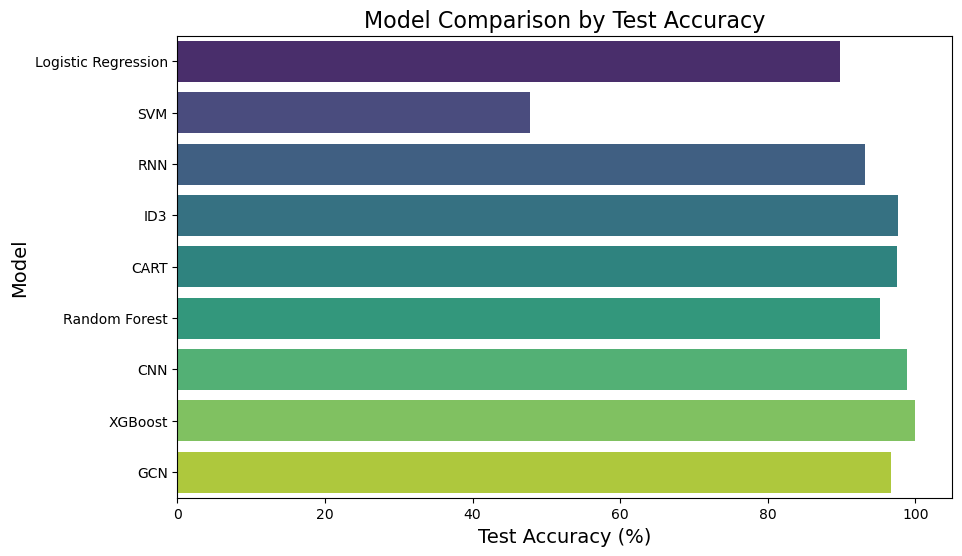

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 结果汇总
results = {
    'Model': ['Logistic Regression', 'SVM', 'RNN', 'ID3', 'CART', 'Random Forest', 'CNN', 'XGBoost', 'GCN'],
    'Test Accuracy (%)': [
        accuracy_log_reg * 100,
        accuracy_svm * 100,
        accuracy * 100,  # RNN的准确率
        id3_accuracy * 100,
        cart_accuracy * 100,
        rf_accuracy * 100,  # Random Forest的准确率
        cnn_accuracy * 100,  # CNN的准确率
        accuracy_xgb * 100,  # XGBoost的准确率
        accuracy_gcn * 100   # GCN的准确率
    ]
}

# 创建DataFrame
results_df = pd.DataFrame(results)

# 打印结果
print("Model Comparison:")
print(results_df.sort_values(by='Test Accuracy (%)', ascending=False))

# 绘制条形图
plt.figure(figsize=(10, 6))
sns.barplot(x='Test Accuracy (%)', y='Model', data=results_df, palette='viridis')

# 添加标题和标签
plt.title('Model Comparison by Test Accuracy', fontsize=16)
plt.xlabel('Test Accuracy (%)', fontsize=14)
plt.ylabel('Model', fontsize=14)

# 显示图表
plt.show()
